# OGGM - data pulling

Adds topographical variables from OGGM to the PMB data.

## Setting up:

In [12]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
import salem
from tqdm.notebook import tqdm
import logging
import matplotlib.pyplot as plt
from oggm import utils, workflow, tasks
from oggm import cfg as oggmCfg
import os
import re
import seaborn as sns
import math
from os.path import isfile, join, isdir
from shapely.geometry import Point

oggmCfg.initialize(logging_level='WARNING')
oggmCfg.PARAMS['border'] = 10
oggmCfg.PARAMS['use_multiprocessing'] = True
oggmCfg.PARAMS['continue_on_error'] = True
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2025-04-14 14:23:42: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-04-14 14:23:42: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-04-14 14:23:42: oggm.cfg: Multiprocessing: using all available processors (N=32)
2025-04-14 14:23:42: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-04-14 14:23:42: oggm.cfg: Multiprocessing switched ON after user settings.
2025-04-14 14:23:42: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [13]:
def emptyfolder(path):
    if os.path.exists(path):
        # Loop through all items in the directory
        for item in os.listdir(path):
            item_path = join(path, item)
            if isfile(item_path):
                os.remove(item_path)  # Remove file
            elif isdir(item_path):
                emptyfolder(item_path)  # Recursively empty the folder
                os.rmdir(item_path)  # Remove the now-empty folder
    else:
        createPath(path)


def createPath(path):
    os.makedirs(path, exist_ok=True)

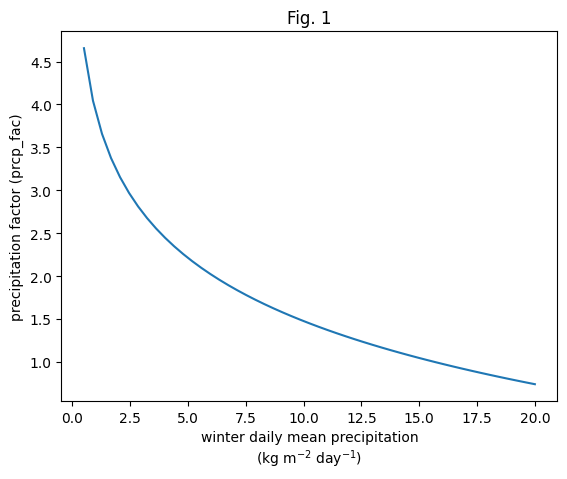

In [14]:
w_prcp_array = np.linspace(0.5, 20, 51)
# we basically do here the same as in massbalance.decide_winter_precip_factor(gdir)
a, b = oggmCfg.PARAMS['winter_prcp_fac_ab']
r0, r1 = oggmCfg.PARAMS['prcp_fac_min'], oggmCfg.PARAMS['prcp_fac_max']
prcp_fac = a * np.log(w_prcp_array) + b
# don't allow extremely low/high prcp. factors!!!
prcp_fac_array = utils.clip_array(prcp_fac, r0, r1)
plt.plot(w_prcp_array, prcp_fac_array)
plt.xlabel(r'winter daily mean precipitation' + '\n' +
           r'(kg m$^{-2}$ day$^{-1}$)')
plt.ylabel('precipitation factor (prcp_fac)')
plt.title('Fig. 1')

# save arrays
np.save('w_prcp_array.npy', w_prcp_array)
np.save('prcp_fac_array.npy', prcp_fac_array)

## Download OGGM data:

In [15]:
# set working directory
working_dir = '/home/mburlet/scratch/data/DATA_MB/OGGM/'
oggmCfg.PATHS['working_dir'] = working_dir

# Set RGI version and region:
rgi_region = "11"  # Central Europe
rgi_version = "6"
rgi_dir = utils.get_rgi_dir(version=rgi_version)

In [16]:
path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# We use the directories with the shop data in it: "W5E5_w_data"
base_url = "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/"
gdirs = workflow.init_glacier_directories(
    rgidf,
    from_prepro_level=3,
    prepro_base_url=base_url,
    prepro_border=10,
    reset=True,
    force=True,
)

# Tested tasks
task_list = [
    tasks.gridded_attributes,
    # tasks.gridded_mb_attributes,
    # get_gridded_features,
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs, print_log=False)



# Load PMB data:
path_PMB_GLACIOCLIM_csv = '/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/WGMS_all/'
df_pmb = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/WGMS_all/FR_wgms_dataset_all.csv')
uniquergis = df_pmb['RGIId'].unique()
RUN = True
if RUN:
    # Save OGGM xr for all needed glaciers (can extend to all glaciers if remove if condition):
    emptyfolder('/home/mburlet/scratch/data/DATA_MB/OGGM/xr_grids/')
    for gdir in gdirs:
        RGIId = gdir.rgi_id
        if RGIId not in uniquergis:
            continue
        with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
            ds = ds.load()
        # save ds
        ds.to_netcdf(f'/home/mburlet/scratch/data/DATA_MB/OGGM/xr_grids/{RGIId}.nc')

2025-04-14 14:23:53: oggm.workflow: init_glacier_directories from prepro level 3 on 3927 glaciers.
2025-04-14 14:23:53: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3927 glaciers
2025-04-14 14:24:10: oggm.workflow: Execute entity tasks [gridded_attributes] on 3927 glaciers


## Load PMB data:

In [17]:
print('Number of winter, summer and annual samples:', len(df_pmb))
print('Number of annual samples:',
      len(df_pmb[df_pmb.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb[df_pmb.PERIOD == 'winter']))

# Get OGGM info of one sample:
RGI = df_pmb.iloc[0].RGIId
# Get oggm data for that RGI ID
for gdir in gdirs:
    if gdir.rgi_id == RGI:
        break
with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
    ds = ds.load()
ds

Number of winter, summer and annual samples: 10788
Number of annual samples: 4687
Number of winter samples: 3347


<xarray.Dataset> Size: 945kB
Dimensions:                  (x: 138, y: 129)
Coordinates:
  * x                        (x) float32 552B -3.574e+03 -3.512e+03 ... 4.92e+03
  * y                        (y) float32 516B 5.092e+06 5.092e+06 ... 5.084e+06
Data variables: (12/17)
    topo                     (y, x) float32 71kB 1.444e+03 ... 3.171e+03
    topo_smoothed            (y, x) float32 71kB 1.436e+03 ... 3.184e+03
    topo_valid_mask          (y, x) int8 18kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 18kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 18kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 71kB nan nan nan nan ... nan nan nan
    ...                       ...
    glacier_ext_erosion      (y, x) int8 18kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    ice_divides              (y, x) int8 18kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    slope                    (y, x) float32 71kB 0.2633 0.2997 ... 0.3657 0.3419
    aspect                   (y, x) float32 71kB 3.811 3.992 ... 3.899 3.735
    slope_factor             (y, x) float32 71kB 2.227 2.061 ... 1.829 1.904
    dis_from_border          (y, x) float32 71kB 964.5 921.7 ... 1.406e+03
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=6.985 +k=0.9996 +x_0=0 +y_0=0...
    max_h_dem:      4080.0
    min_h_dem:      1319.0
    max_h_glacier:  3728.0
    min_h_glacier:  1539.0

## Merge with OGGM data:

In [18]:
# load shapefiles
# Load RGI shapefile for the specified region and version
path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# All possible variables of interest from oggm
# voi = [
#     "aspect", "slope", "dis_from_border", "topo", "hugonnet_dhdt",
#     "consensus_ice_thickness", "millan_ice_thickness", "millan_v", "millan_vx",
#     "millan_vy"
# ]

voi = [
    "aspect",
    "slope",
    "topo",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

# Initialise empty:
for var in voi:
    df_pmb[var] = np.nan
   
df_pmb['within_glacier_shape'] = False
    
grouped = df_pmb.groupby("RGIId")

# Process each group
for rgi_id, group in grouped:
    # Get oggm data for that RGI ID
    for gdir in gdirs:
        if gdir.rgi_id == rgi_id:
            break

    with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
        ds = ds.load()
        
    # Find the specific shape for the current RGI ID
    glacier_shape = rgidf[rgidf["RGIId"] == rgi_id]
    if glacier_shape.empty:
        print(f"Warning: No shape found for RGIId {rgi_id}, skipping...")
        continue

    # Define the coordinate transformation
    transf = pyproj.Transformer.from_proj(
        pyproj.CRS.from_user_input("EPSG:4326"),  # Input CRS (WGS84)
        pyproj.CRS.from_user_input(ds.pyproj_srs),  # Output CRS from dataset
        always_xy=True
    )
    
    # Transform all coordinates in the group
    lon, lat = group["POINT_LON"].values, group["POINT_LAT"].values
    x_stake, y_stake = transf.transform(lon, lat)
    
    # Create a GeoDataFrame for df_pmb points
    geometry = [Point(xy) for xy in zip(group["POINT_LON"], group["POINT_LAT"])]
    points_rgi = gpd.GeoDataFrame(group, geometry=geometry, crs="EPSG:4326")

    # Filter points that intersect with this specific shape
    glacier_shape = glacier_shape.to_crs(points_rgi.crs)  # Ensure CRS matches
    points_in_glacier = gpd.sjoin(points_rgi.loc[group.index], glacier_shape, predicate="within", how="inner")
            
    # Select nearest values for all points
    stake = ds.sel(
        x=xr.DataArray(x_stake, dims="points"),
        y=xr.DataArray(y_stake, dims="points"),
        method="nearest"
    )

    # Extract variables of interest
    stake_var = stake[voi]

    # Convert the extracted data to a DataFrame
    stake_var_df = stake_var.to_dataframe()

    # Update the DataFrame with the extracted values
    for var in voi:
        df_pmb.loc[group.index, var] = stake_var_df[var].values
    
    df_pmb.loc[points_in_glacier.index, 'within_glacier_shape'] = True
    
# change from radians to degrees so that it agrees with sgi data
df_pmb['aspect'] = df_pmb['aspect'].apply(lambda x: math.degrees(x))
df_pmb['slope'] = df_pmb['slope'].apply(lambda x: math.degrees(x))

In [19]:
print(df_pmb)

                                                POINT_ID  POINT_LAT  \
0      Argentiere_Tour_Noir_annual_smb_abl_2006_setup...  45.944607   
1      Argentiere_Tour_Noir_annual_smb_abl_2006_setup...  45.943724   
2      Argentiere_Tour_Noir_annual_smb_abl_2006_setup...  45.943192   
3      Argentiere_Tour_Noir_annual_smb_abl_2006_setup...  45.942539   
4      Argentiere_Tour_Noir_annual_smb_abl_2007_setup...  45.944594   
...                                                  ...        ...   
10783              stso_winter_smb_accu_2022_setup2022_6  45.153887   
10784              stso_winter_smb_accu_2022_setup2022_7  45.152499   
10785             stso_winter_smb_accu_2022_setup2022_10  45.156253   
10786             stso_winter_smb_accu_2022_setup2022_11  45.164111   
10787              stso_winter_smb_accu_2022_setup2022_8  45.153943   

       POINT_LON  POINT_ELEVATION  FROM_DATE   TO_DATE  POINT_BALANCE  \
0       7.024819          3033.52   20050930  20061004          -0.67   
1

/tmp/ipykernel_2935418/1358111563.py:37: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(df_stakes, x='x', y='y', hue='within_glacier_shape', palette=['r', 'b'])
/tmp/ipykernel_2935418/1358111563.py:37: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(df_stakes, x='x', y='y', hue='within_glacier_shape', palette=['r', 'b'])
/tmp/ipykernel_2935418/1358111563.py:37: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(df_stakes, x='x', y='y', hue='within_glacier_shape', palette=['r', 'b'])
/tmp/ipykernel_2935418/1358111563.py:37: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(df_stakes, x='x', y='y', hue='within_glacier_shape', palette=['r', 'b'])
/tmp/ipykernel_2935418/1358111563.py:37: UserWarning: The palette list has more values (2) than 

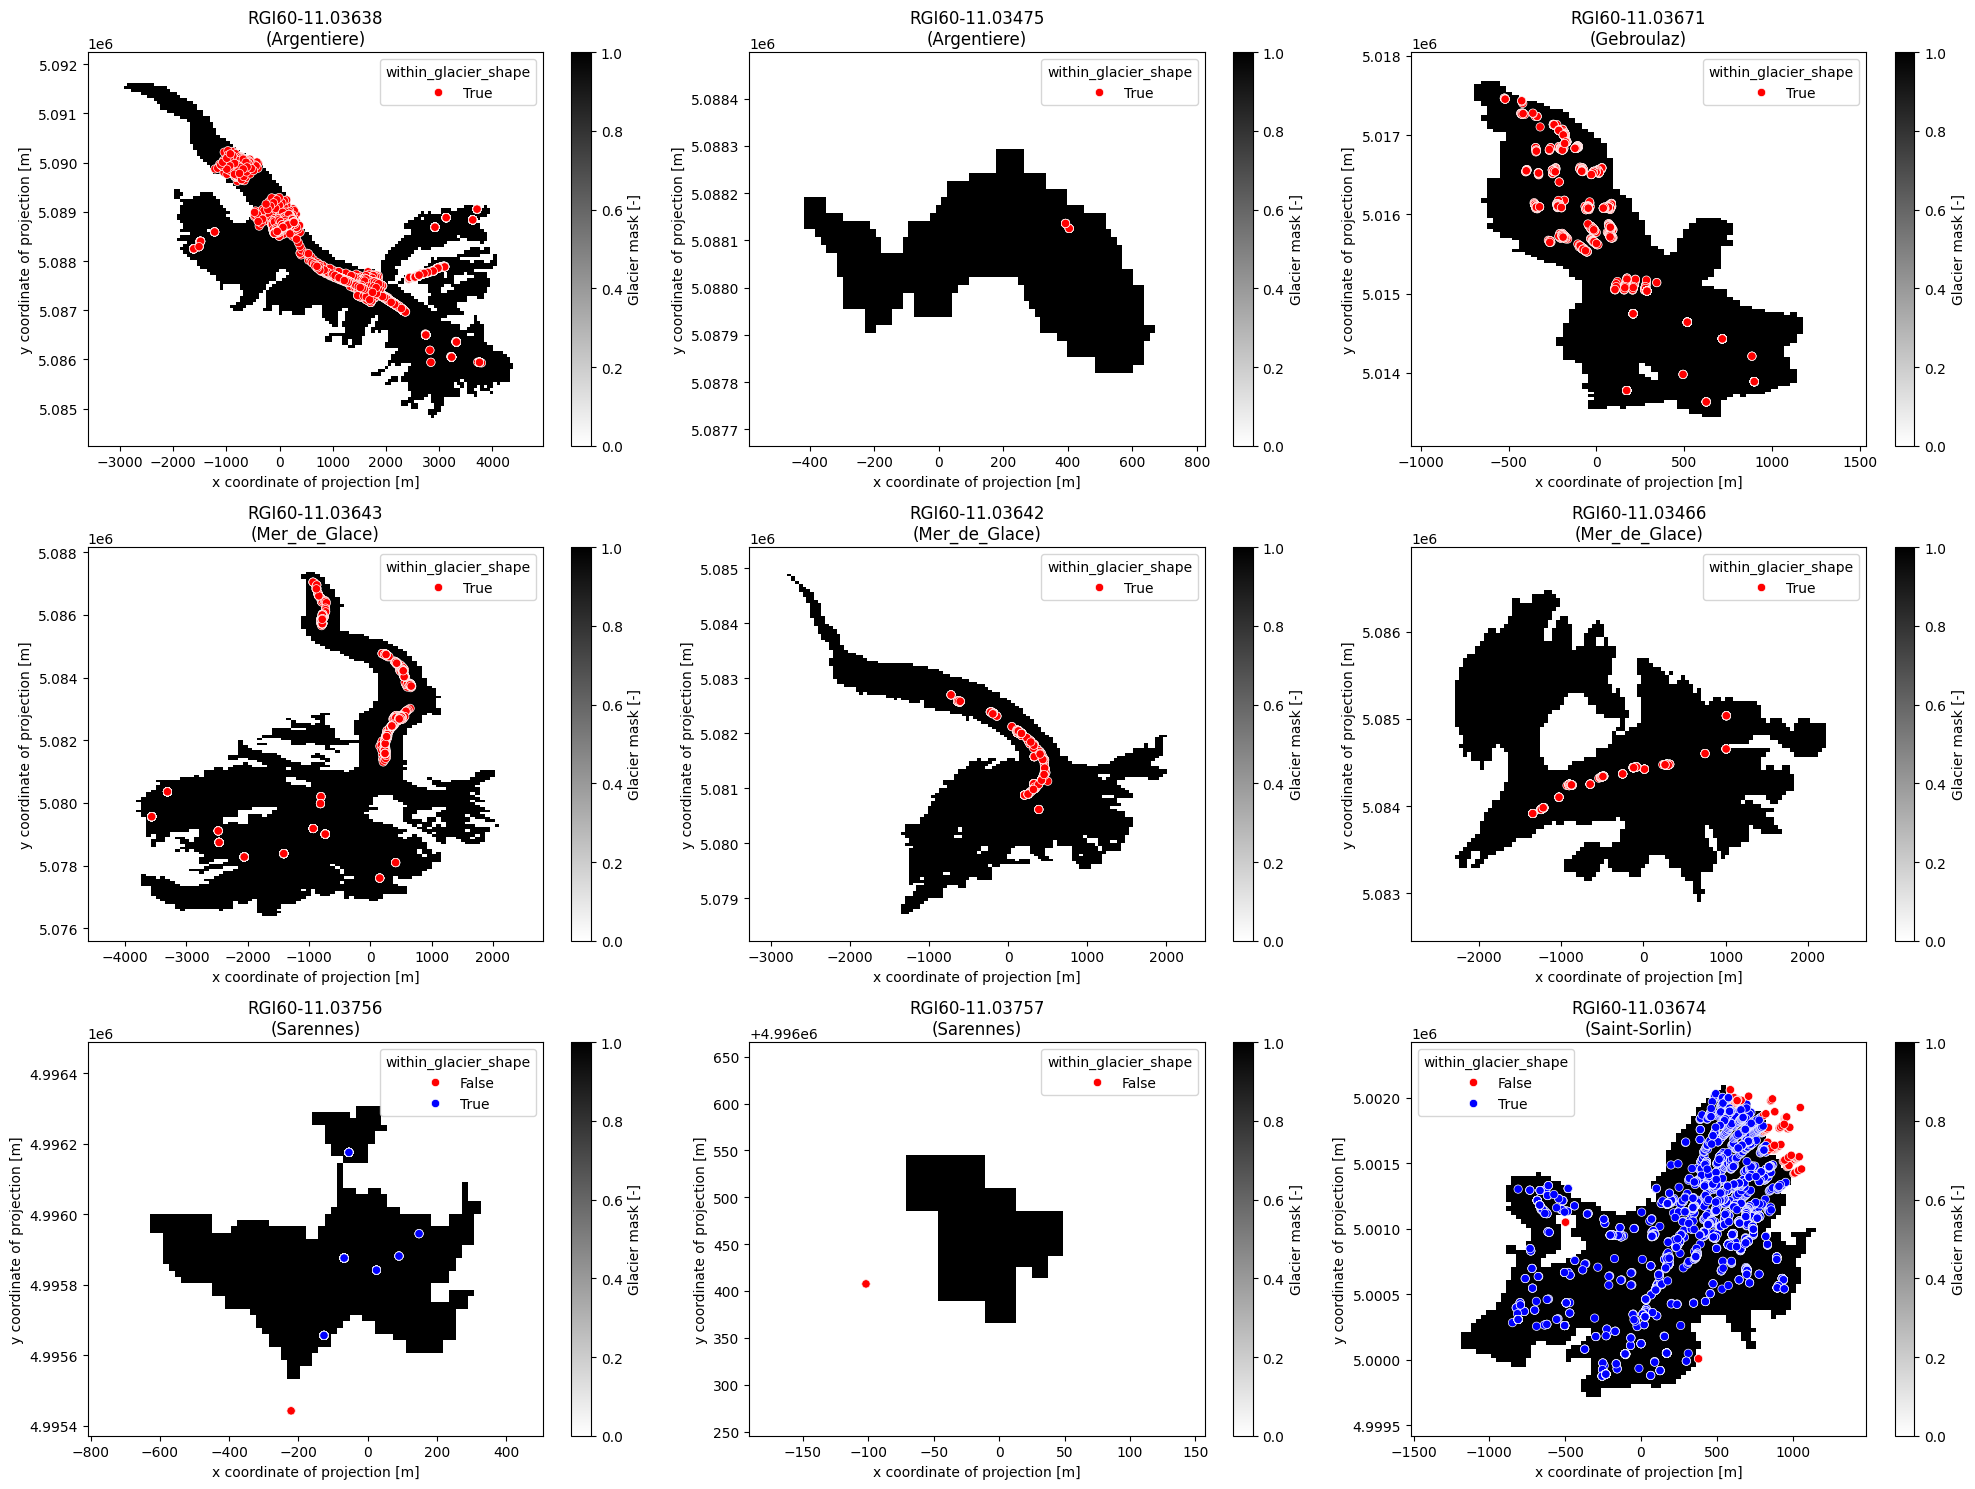

In [21]:
plt.figure(figsize=(20, 15))

# List all RGI IDs
rgi_ids = ['RGI60-11.03638', 'RGI60-11.03475', 'RGI60-11.03671', 'RGI60-11.03643',
          'RGI60-11.03642', 'RGI60-11.03466', 'RGI60-11.03756', 'RGI60-11.03757',
          'RGI60-11.03674']

# Plot each glacier in its own subplot
for i, rgi_id in enumerate(rgi_ids, 1):
    plt.subplot(3, 3, i)
    
    # Get stakes data
    df_stakes = df_pmb[(df_pmb['RGIId'] == rgi_id)].copy()
    
    # Skip if no data
    if len(df_stakes) == 0:
        plt.title(f"{rgi_id} (No data)")
        continue
        
    # Open OGGM data and transform coordinates
    try:
        ds_oggm = xr.open_dataset(f'/home/mburlet/scratch/data/DATA_MB/OGGM/xr_grids/{rgi_id}.nc')
        transf = pyproj.Transformer.from_proj(
            pyproj.CRS.from_user_input("EPSG:4326"),
            pyproj.CRS.from_user_input(ds_oggm.pyproj_srs),
            always_xy=True
        )
        
        # Transform coordinates
        lon, lat = df_stakes["POINT_LON"].values, df_stakes["POINT_LAT"].values
        x_stake, y_stake = transf.transform(lon, lat)
        df_stakes['x'] = x_stake
        df_stakes['y'] = y_stake
        
        # Plot
        ds_oggm.glacier_mask.plot(cmap='binary')
        sns.scatterplot(df_stakes, x='x', y='y', hue='within_glacier_shape', palette=['r', 'b'])
        
        # Add glacier name to title if available
        glacier_name = df_stakes['GLACIER'].iloc[0] if 'GLACIER' in df_stakes.columns else ""
        plt.title(f"{rgi_id}\n({glacier_name})")
        
    except FileNotFoundError:
        plt.title(f"{rgi_id} (File not found)")
    except Exception as e:
        plt.title(f"{rgi_id} (Error)")

plt.tight_layout()
plt.show()

In [22]:
# Save to csv:
# Drop points that are not within the glacier shape
df_pmb = df_pmb[df_pmb['within_glacier_shape']]
# Drop the within_glacier_shape column
df_pmb = df_pmb.drop(columns=['within_glacier_shape'])

print('Number of winter and annual samples:', len(df_pmb))
print('Number of annual samples:',
      len(df_pmb[df_pmb.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb[df_pmb.PERIOD == 'winter']))
# Save to csv
df_pmb.to_csv(path_PMB_GLACIOCLIM_csv + f'FR_wgms_dataset_all_oggm.csv',
              index=False)
df_pmb.head(3)

Number of winter and annual samples: 10623
Number of annual samples: 4570
Number of winter samples: 3322


,POINT_ID,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,GLACIER,PERIOD,GLACIER_ZONE,RGIId,YEAR,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v
0,Argentiere_Tour_Noir_annual_smb_abl_2006_setup...,45.944607,7.024819,3033.52,20050930,20061004,-0.67,Argentiere,annual,Tour Noir,RGI60-11.03638,2006,253.839254,22.267489,3025.0,-1.019441,41.007587,5.479116
1,Argentiere_Tour_Noir_annual_smb_abl_2006_setup...,45.943724,7.022022,2941.68,20050930,20061004,-0.61,Argentiere,annual,Tour Noir,RGI60-11.03638,2006,246.198458,21.827929,2944.0,-1.244668,48.157185,2.614753
2,Argentiere_Tour_Noir_annual_smb_abl_2006_setup...,45.943192,7.019273,2862.05,20050930,20061004,-2.94,Argentiere,annual,Tour Noir,RGI60-11.03638,2006,250.211112,14.903008,2857.0,-1.376595,36.716553,3.574035
